# <b> COMPARISON OF DISTINCT CNN BACKBONE ARCHITECTURES WITH DENSE HEADS, ATTENTION AND VISUAL TRANSFORMERS ON MEDICAL X-RAY IMAGE DATASET </b>

## AASD 4015 - Advance Mathematical Concepts for Deep Learning Group Project 2

<b>Members:</b> 
1. Saksham Prakash (101410709) 
2. Sik Yin Sun (101409665)

Project GitHub: https://github.com/SikYinSun/AASD-4015---COVID-19-Detection

## Background and Motivation

The COVID-19 pandemic has had a profound impact on global health and early diagnosis of COVID-19 is critical for effective management of the disease.

For this project, we explore <b> different backbone architecures </b> and their results on a binary-classification task using images of X-Rays of patients with/without the disease. 
Additionally, since the <b> attention mechanism </b> has been quite successful recently, our attempts on utilizing the same for our purpose, has been detailed as well.

---

In the context of COVID screening from X-rays, a <b> high recall would be preferred over high precision </b>. This is because the consequences of a false negative - i.e., failing to identify a COVID-19 infection in a patient who actually has the disease - can be severe. Patients with COVID-19 can develop severe symptoms and require urgent medical attention, and failure to detect the disease can result in delayed treatment and increased transmission.

On the other hand, the consequences of a false positive - i.e., identifying a patient as having COVID-19 when they do not - are less severe. In the case of false positives, the patient may be required to undergo additional testing or quarantine measures, but this is a relatively minor inconvenience compared to the potential harm of a false negative.

Therefore, in the case of COVID screening from X-rays, a high recall model that detects as many true positive cases as possible, even if it results in some false positives, is preferred over a high precision model that minimizes false positives at the expense of potentially missing true positive cases.

---

## Problem Statement

1. The objective is to develop a binary classification model capable of distinguishing between COVID-19 infected and non-infected individuals using a chest X-ray image of a patient.
2. Compare the efficacy of different backbone architectures with dense heads, attention heads and visual transformers for this purpose.

## Contents

| SNo. | Contents | Link |
| -------- | -------- | -------- |
| 1 | <b> Libraries Setup </b> | [Jump To Cell](#lib)
| 2 | <b> Data - Chest X-Rays </b>| [Jump To Cell](#data)
| 2.1 | Download | [Jump To Cell](#download)
| 2.2 | Initial Exploration | [Jump To Cell](#initData)
| 2.3 | Handling Class Imbalance by Oversampling | [Jump To Cell](#oversample)
| 3 | <b> Helper Functions to Evaluate Model Trainings Uniformally </b>| [Jump To Cell](#helper)
| 4 | <b> Training Simple Dense Heads for Implementing Baseline Backbone Architectures </b>| [Jump To Cell](#backbone)
| 4.1 | VGG-16 | [Jump To Cell](#vgg16)
| 4.2 | InceptionV3  | [Jump To Cell](#iv3)
| 4.3 | EffientNetV2B3  | [Jump To Cell](#effnet)
| 5 | <b> Using Attention Mechanism </b>| [Jump To Cell](#att)
| 5.1 | VGG-16 backbone with Self-Attention | [Jump To Cell](#selfAtt)
| 5.2 | VGG-16 backbone with Multi-Head Attention | [Jump To Cell](#multHead)
| 6 | <b> Visual Transformers (ViT) </b>| [Jump To Cell](#vit)
| 7 | <b> Results </b>| [Jump To Cell](#results)
| 8 | <b> Conclusion </b>| [Jump To Cell](#conclusion)
| 9 | <b> Learning Outcomes </b> | [Jump To Cell](#learningOuts)
| 10 | <b> References </b> | [Jump To Cell](#ref)


## <b> 1. Libraries Setup </b>
<a id='lib'></a>

### 1.1 Downloading Packages

In [1]:
!pip install tensorflow-addons vit-keras typing_extensions typeguard seaborn scikit-learn seaborn opencv-python kaggle imbalanced-learn

### 1.2 Imports

In [2]:
import os
import numpy as np
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import gc

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, inception_v3, efficientnet_v2
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from vit_keras import vit

from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2023-04-06 11:49:13.823648: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 11:49:14.719119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ubuntu/AASD-4015---COVID-19-Detection/covid/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, e

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-04-06 11:49:16.414570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 11:49:16.460236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 11:49:16.460516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## <b>2. Data - Chest X-Rays</b>
<a id='data'></a>
<font size=3>The link of Data:</font>
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

### 2.1 Download
<a id='download'></a>

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "."
if not os.path.exists('chest_xray'):
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --unzip

In [5]:
train_dir = os.path.join('.','chest_xray','train')
val_dir = os.path.join('.','chest_xray','val')
test_dir = os.path.join('.','chest_xray','test')

In [6]:
img_height = 320
img_width = 320
batch_size = 16
seed = 9876

### 2.2 Initial Exploration
<a id='initData'></a>

In [7]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir, image_size=(img_height, img_width), batch_size = batch_size, shuffle = True, seed=seed)
val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir, image_size=(img_height, img_width), batch_size = batch_size, shuffle = True, seed=seed)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size=(img_height, img_width), batch_size = batch_size, shuffle = True, seed=seed)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


2023-04-06 11:49:17.059530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 11:49:17.059857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 11:49:17.060076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
class_label = train_data.class_names
train_num = []
val_num = []
test_num = []
print("Train Data")
for i in class_label:
    num_files = len(os.listdir(os.path.join(train_dir, i)))
    train_num.append(num_files)
    print(f"{i}: {num_files} files")

print("\nValidation Data")
for i in class_label:
    num_files = len(os.listdir(os.path.join(val_dir, i)))
    val_num.append(num_files)
    print(f"{i}: {num_files} files")

print("\nTest Data")
for i in class_label:
    num_files = len(os.listdir(os.path.join(test_dir, i)))
    test_num.append(num_files)
    print(f"{i}: {num_files} files")

Train Data
NORMAL: 1341 files
PNEUMONIA: 3875 files

Validation Data
NORMAL: 8 files
PNEUMONIA: 8 files

Test Data
NORMAL: 234 files
PNEUMONIA: 390 files


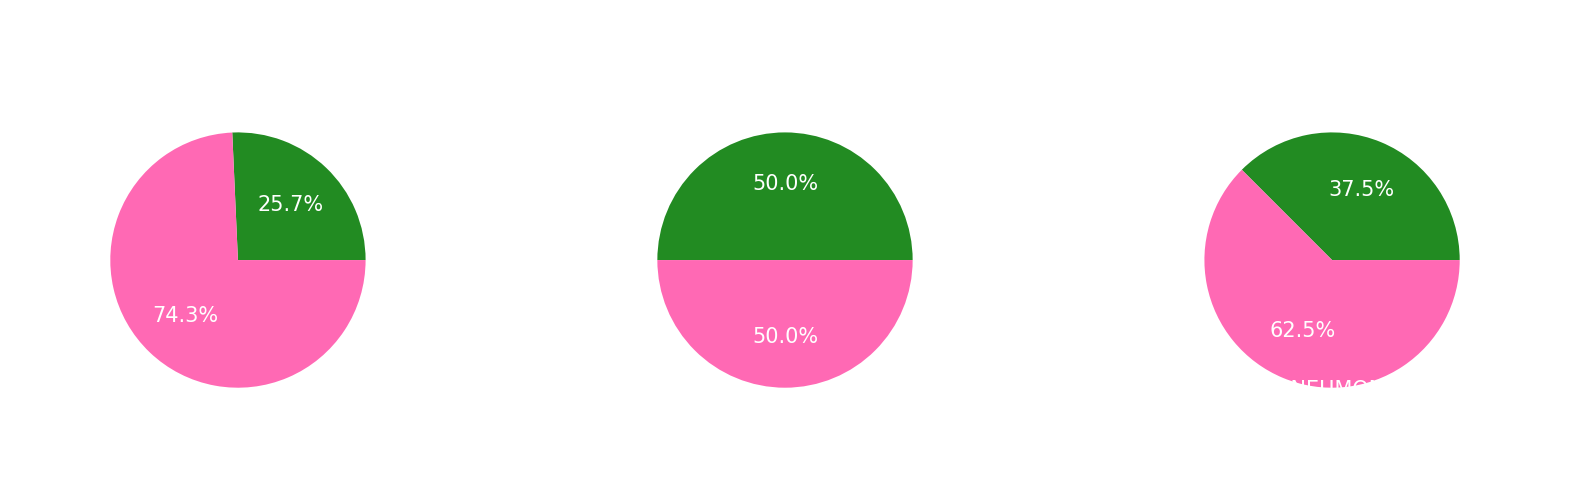

In [9]:
colors = ['#228b22', '#ff69b4']
fig, axs = plt.subplots(ncols=3, figsize=(20, 6))
axs[0].pie(train_num, labels=class_label, autopct='%1.1f%%', colors = colors, textprops={'color': 'white', 'fontsize': 15}, radius=0.7, center=(0.5, 0.5))
axs[0].set_title('Distribution of Images Across Classes for Train Data', color="white")
axs[1].pie(val_num, labels=class_label, autopct='%1.1f%%', colors = colors, textprops={'color': 'white', 'fontsize': 15}, radius=0.7, center=(0.5, 0.5))
axs[1].set_title('Distribution of Images Across Classes for Validation Data', color="white")
axs[2].pie(test_num, labels=class_label, autopct='%1.1f%%', colors = colors, textprops={'color': 'white', 'fontsize': 15}, radius=0.7, center=(0.5, 0.5))
axs[2].set_title('Distribution of Images Across Classes for Test Data', color="white")
plt.show()

2023-04-06 11:49:19.005234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5216]
	 [[{{node Placeholder/_0}}]]
2023-04-06 11:49:19.005648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5216]
	 [[{{node Placeholder/_4}}]]


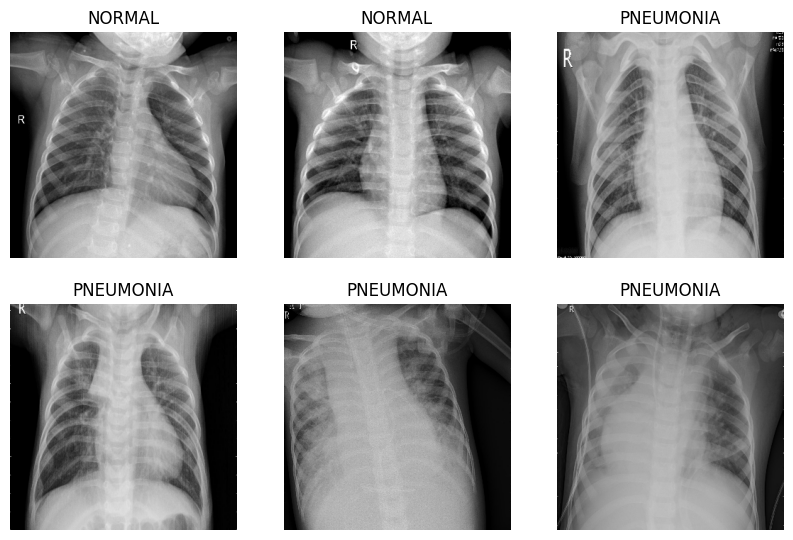

In [10]:
plt.figure(figsize = (10,10))
for images, labels in train_data.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_label[labels[i]])
    plt.axis('off')

In [11]:
del train_data
del val_data
del test_data
gc.collect()

463

### 2.3 Handling Class Imbalance by Oversampling
<a id='oversample'></a>

In [12]:
def load_images_from_directory(dir_path, class_names, target_size=(320, 320)):
    images = []
    labels = []
    for class_name in class_names:
        class_dir = os.path.join(dir_path, class_name)
        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(class_names.index(class_name))
    return np.array(images), np.array(labels)

def get_balanced_train_data(train_dir, class_names, img_height, img_width):
    X, y = load_images_from_directory(train_dir, class_names, target_size=(img_height, img_width))
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X.reshape(X.shape[0], -1), y)
    X_resampled = X_resampled.reshape(X_resampled.shape[0], img_height, img_width, 3)
    X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=42)
    return X_resampled, y_resampled

def create_dataset(X, y, batch_size=16):
    X = X.astype('float32') / 255.0 
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [13]:
X, y = get_balanced_train_data(train_dir, class_label, img_height, img_width)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)
train_data = create_dataset(X_train, y_train, batch_size=16)
val_data = create_dataset(X_val, y_val, batch_size=16)

2023-04-06 11:50:24.641693: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 7618560000 exceeds 10% of free system memory.
2023-04-06 11:50:31.888464: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 7618560000 exceeds 10% of free system memory.


In [14]:
X_test, y_test = get_balanced_train_data(test_dir, class_label, img_height, img_width)
test_data = create_dataset(X_test, y_test, batch_size=16)

<font size=3>After briefly exploring the data, we found out that there is a vast difference between "normal" and "pneumonia" for the train data. Additionally, we found that there is more pneumonia record than normal. From the image above, we can see them for people with pneumonia. Their X-ray pictures are much blurry than normal people, and we believe that is because the lung infection causes some fluid there.</font>

In [15]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([3110, 3090]))
(array([0, 1]), array([765, 785]))
(array([0, 1]), array([390, 390]))


## <b> 3. Helper Functions to Evaluate Model Trainings Uniformally </b>
<a id='helper'></a>

In [16]:
def plot_accuracy_and_loss(history):
    fig, ax = plt.subplots(ncols=2, figsize=(25, 8))

    ax[0].plot(history.history['accuracy'], label="Train accuracy")
    ax[0].plot(history.history['val_accuracy'], label="Validation accuracy")
    ax[0].set_title("Model accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("accuracy")
    ax[0].legend(["train", "val"])
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(history.history['loss'], label="Train loss")
    ax[1].plot(history.history['val_loss'], label="Validation loss")
    ax[1].set_title("Model loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("loss")
    ax[1].legend(["train", "val"])
    ax[1].grid(True)
    ax[1].legend()

    plt.show()

def print_confusion_matrix(y_true, y_pred):
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5, cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def print_classification_report(y_true, y_pred, class_names):
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=1))

def evaluate_model(model, train_dataset, val_dataset, test_dataset, epochs=10, class_names=class_label):
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

    print("\nModel Summary:")
    print(model.summary())

    plot_accuracy_and_loss(history)

    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"\nTest accuracy: {test_accuracy}, Test loss: {test_loss}")
    
    y_true = np.concatenate([y for _, y in test_dataset], axis=0)
    y_pred = np.squeeze(np.round(model.predict(test_dataset)))

    print_confusion_matrix(y_true, y_pred)
    print_classification_report(y_true, y_pred, class_names)

## <b> 4. Training Simple Dense Heads for Implementing Baseline Backbone Architectures </b>
<a id='backbone'></a>

### 4.1 VGG-16
<a id='vgg16'></a>

In [17]:
image_size = (img_height, img_width,3) 
vgg16 = VGG16(include_top = False, weights = 'imagenet',input_shape = image_size)

for layer in vgg16.layers:
    layer.trainable = False
    
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation="sigmoid")(x)

vgg16 = Model(inputs=vgg16.input, outputs=x)
vgg16.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

2023-04-06 11:50:50.353272: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 7618560000 exceeds 10% of free system memory.
2023-04-06 11:50:58.239422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [6200,320,320,3]
	 [[{{node Placeholder/_0}}]]
2023-04-06 11:50:58.239804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [6200,320,320,3]
	 [[{{node Placeholder/_0}}]]


Epoch 1/10


2023-04-06 11:51:00.340167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-06 11:51:01.299631: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-06 11:51:02.278769: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f6f5b4abf10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-06 11:51:02.278816: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-04-06 11:51:02.286342: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-06 11:51:02.463570: I ./tensorflow/compil

388/388 [==============================] - ETA: 0s - loss: 0.2356 - accuracy: 0.9508

2023-04-06 11:51:21.530883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1550]
	 [[{{node Placeholder/_1}}]]
2023-04-06 11:51:21.531436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1550]
	 [[{{node Placeholder/_1}}]]


388/388 [==============================] - 28s 61ms/step - loss: 0.2356 - accuracy: 0.9508 - val_loss: 0.0397 - val_accuracy: 0.9839
Epoch 2/10
388/388 [==============================] - 20s 51ms/step - loss: 0.0339 - accuracy: 0.9882 - val_loss: 0.0934 - val_accuracy: 0.9748
Epoch 3/10
388/388 [==============================] - 20s 51ms/step - loss: 0.0470 - accuracy: 0.9860 - val_loss: 0.0230 - val_accuracy: 0.9948
Epoch 4/10
388/388 [==============================] - 20s 51ms/step - loss: 0.0055 - accuracy: 0.9982 - val_loss: 0.0231 - val_accuracy: 0.9968
Epoch 5/10
388/388 [==============================] - 20s 51ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0215 - val_accuracy: 0.9968
Epoch 6/10
388/388 [==============================] - 20s 51ms/step - loss: 5.4763e-04 - accuracy: 1.0000 - val_loss: 0.0251 - val_accuracy: 0.9935
Epoch 7/10
388/388 [==============================] - 20s 51ms/step - loss: 2.6993e-04 - accuracy: 1.0000 - val_loss: 0.0299 - val_accuracy: 0.

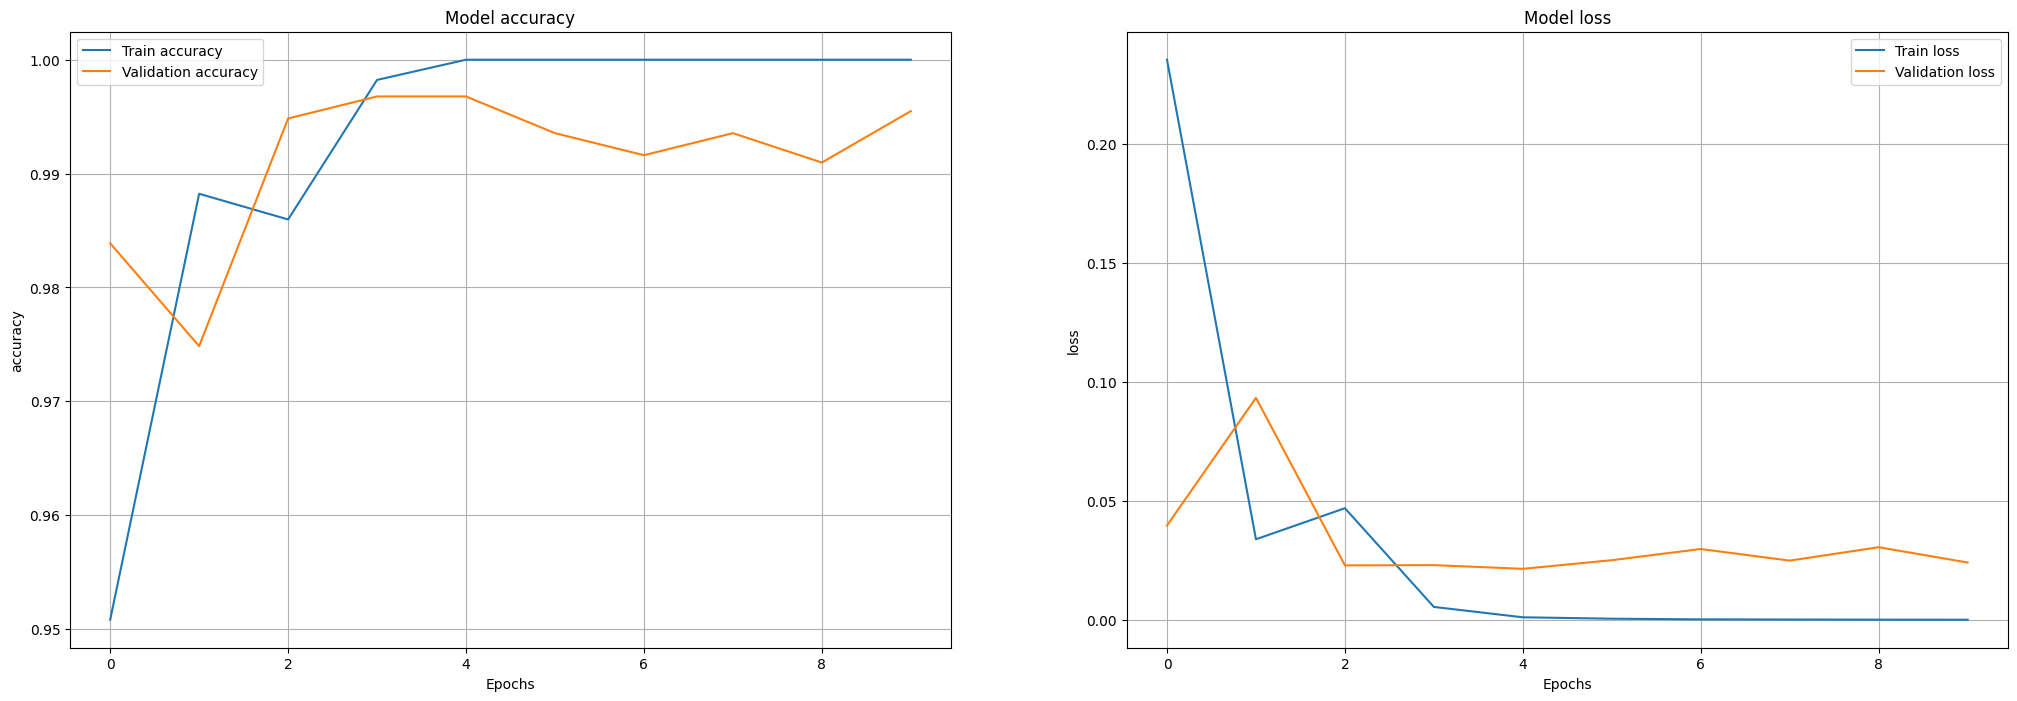

 3/49 [>.............................] - ETA: 1s - loss: 2.3283 - accuracy: 0.7708 

2023-04-06 11:54:26.606418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [780]
	 [[{{node Placeholder/_1}}]]
2023-04-06 11:54:26.606820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [780,320,320,3]
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 4s 59ms/step - loss: 2.8468 - accuracy: 0.6872

Test accuracy: 0.6871795058250427, Test loss: 2.8468077182769775
49/49 [==============================] - 2s 38ms/step

Confusion Matrix:


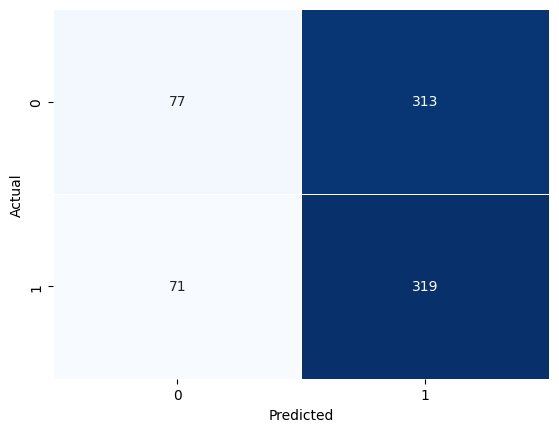


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.52      0.20      0.29       390
   PNEUMONIA       0.50      0.82      0.62       390

    accuracy                           0.51       780
   macro avg       0.51      0.51      0.46       780
weighted avg       0.51      0.51      0.46       780



In [18]:
evaluate_model(model=vgg16, train_dataset=train_data, val_dataset=val_data, test_dataset=test_data, epochs=10)

### 4.2 InceptionV3 
<a id='iv3'></a>

In [19]:
iv3 = inception_v3.InceptionV3(include_top = False, weights = 'imagenet',input_shape = image_size)

for layer in iv3.layers:
    layer.trainable = False
    
x = Flatten()(iv3.output)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation="sigmoid")(x)

iv3 = Model(inputs=iv3.input, outputs=x)
iv3.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

Epoch 1/10
388/388 [==============================] - 24s 47ms/step - loss: 1.9561 - accuracy: 0.9440 - val_loss: 0.1961 - val_accuracy: 0.9865
Epoch 2/10
388/388 [==============================] - 16s 40ms/step - loss: 0.2234 - accuracy: 0.9839 - val_loss: 0.2123 - val_accuracy: 0.9877
Epoch 3/10
388/388 [==============================] - 15s 40ms/step - loss: 0.0682 - accuracy: 0.9935 - val_loss: 0.1612 - val_accuracy: 0.9877
Epoch 4/10
388/388 [==============================] - 16s 40ms/step - loss: 0.0479 - accuracy: 0.9944 - val_loss: 0.0735 - val_accuracy: 0.9897
Epoch 5/10
388/388 [==============================] - 15s 40ms/step - loss: 0.0341 - accuracy: 0.9960 - val_loss: 0.1973 - val_accuracy: 0.9826
Epoch 6/10
388/388 [==============================] - 16s 40ms/step - loss: 0.0476 - accuracy: 0.9955 - val_loss: 0.3256 - val_accuracy: 0.9852
Epoch 7/10
388/388 [==============================] - 16s 40ms/step - loss: 0.0256 - accuracy: 0.9974 - val_loss: 0.2537 - val_accuracy:

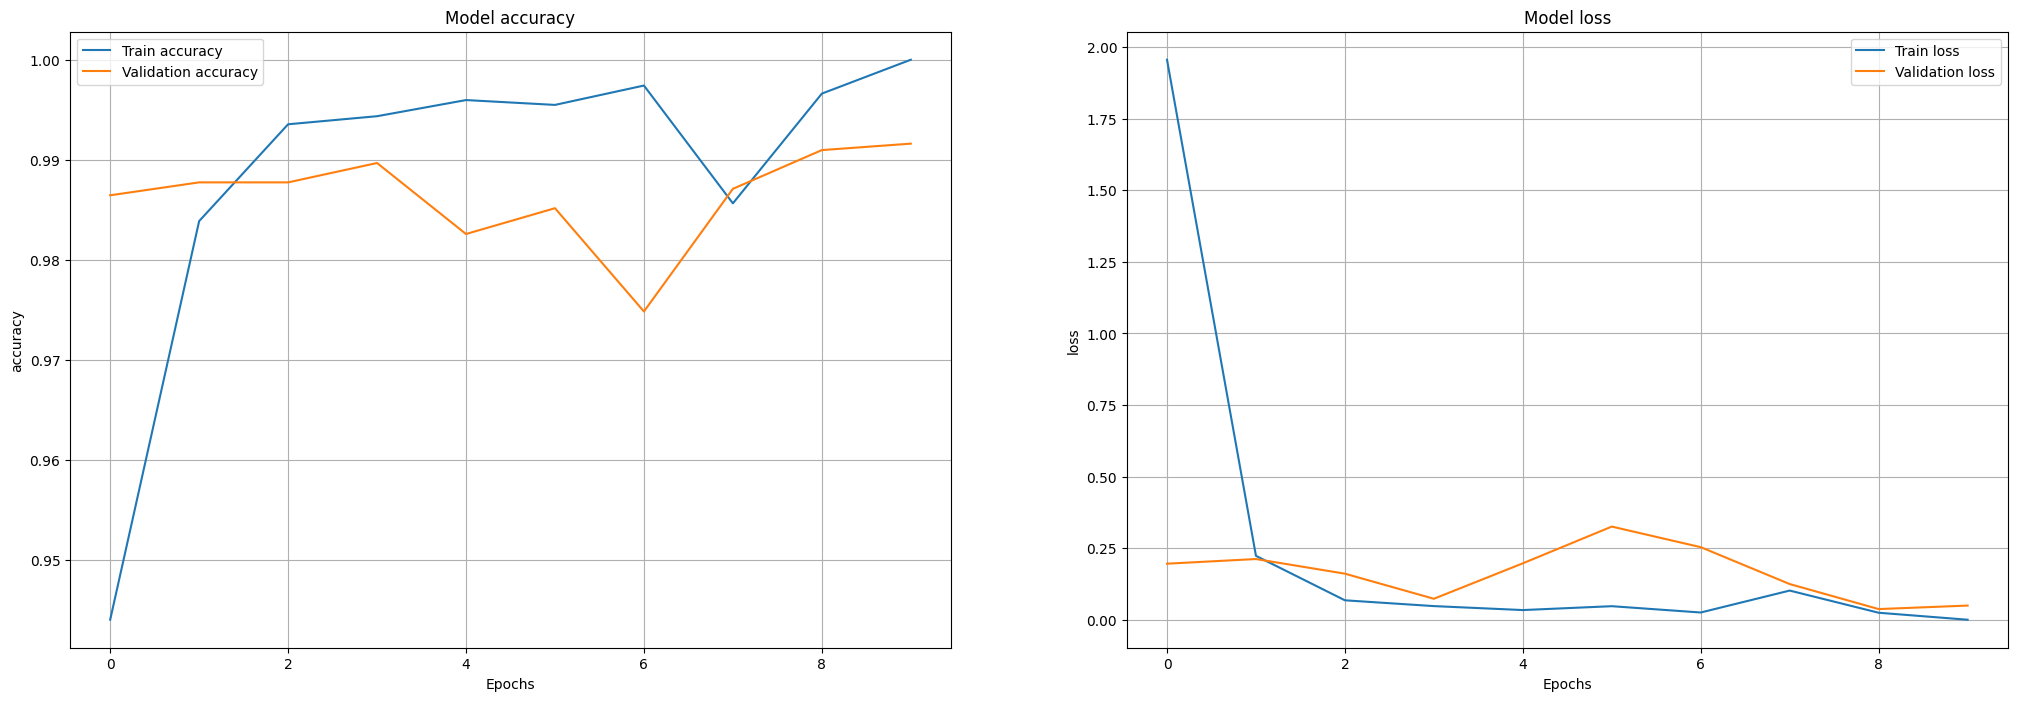

49/49 [==============================] - 2s 45ms/step - loss: 4.0357 - accuracy: 0.7218

Test accuracy: 0.721794843673706, Test loss: 4.035737991333008
49/49 [==============================] - 3s 28ms/step

Confusion Matrix:


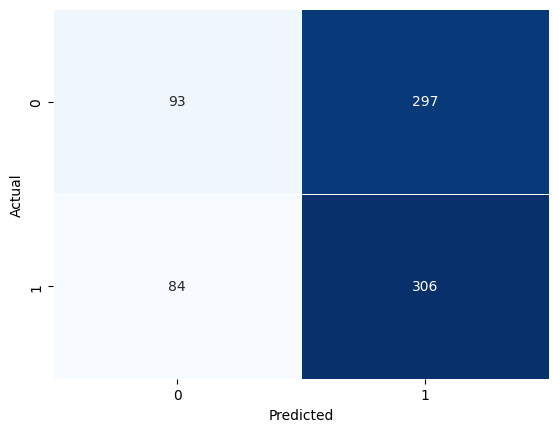


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.53      0.24      0.33       390
   PNEUMONIA       0.51      0.78      0.62       390

    accuracy                           0.51       780
   macro avg       0.52      0.51      0.47       780
weighted avg       0.52      0.51      0.47       780



In [20]:
# history_iv3 = iv3.fit(train_data, epochs=20,validation_data = val_data)
evaluate_model(model=iv3, train_dataset=train_data, val_dataset=val_data, test_dataset=test_data, epochs=10)

### 4.3 EffientNetV2B3 
<a id='effnet'></a>

In [21]:
eff_v2 = efficientnet_v2.EfficientNetV2B3(include_top = False, weights = 'imagenet',input_shape = image_size)

for layer in eff_v2.layers:
    layer.trainable = False
    
x = Flatten()(eff_v2.output)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation="sigmoid")(x)

eff_v2 = Model(inputs=eff_v2.input, outputs=x)
eff_v2.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

Epoch 1/10


2023-04-06 11:57:39.345723: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


388/388 [==============================] - 34s 54ms/step - loss: 3.2189 - accuracy: 0.5026 - val_loss: 1.4658 - val_accuracy: 0.4935
Epoch 2/10
388/388 [==============================] - 17s 44ms/step - loss: 1.5078 - accuracy: 0.5526 - val_loss: 0.7256 - val_accuracy: 0.5052
Epoch 3/10
388/388 [==============================] - 17s 44ms/step - loss: 1.1079 - accuracy: 0.5621 - val_loss: 1.4004 - val_accuracy: 0.5065
Epoch 4/10
388/388 [==============================] - 17s 45ms/step - loss: 0.8051 - accuracy: 0.5924 - val_loss: 0.9591 - val_accuracy: 0.4961
Epoch 5/10
388/388 [==============================] - 17s 45ms/step - loss: 0.8228 - accuracy: 0.5674 - val_loss: 1.7625 - val_accuracy: 0.5065
Epoch 6/10
388/388 [==============================] - 17s 44ms/step - loss: 0.7158 - accuracy: 0.5945 - val_loss: 0.6418 - val_accuracy: 0.5097
Epoch 7/10
388/388 [==============================] - 17s 45ms/step - loss: 0.6901 - accuracy: 0.5619 - val_loss: 0.6912 - val_accuracy: 0.5065
Epo

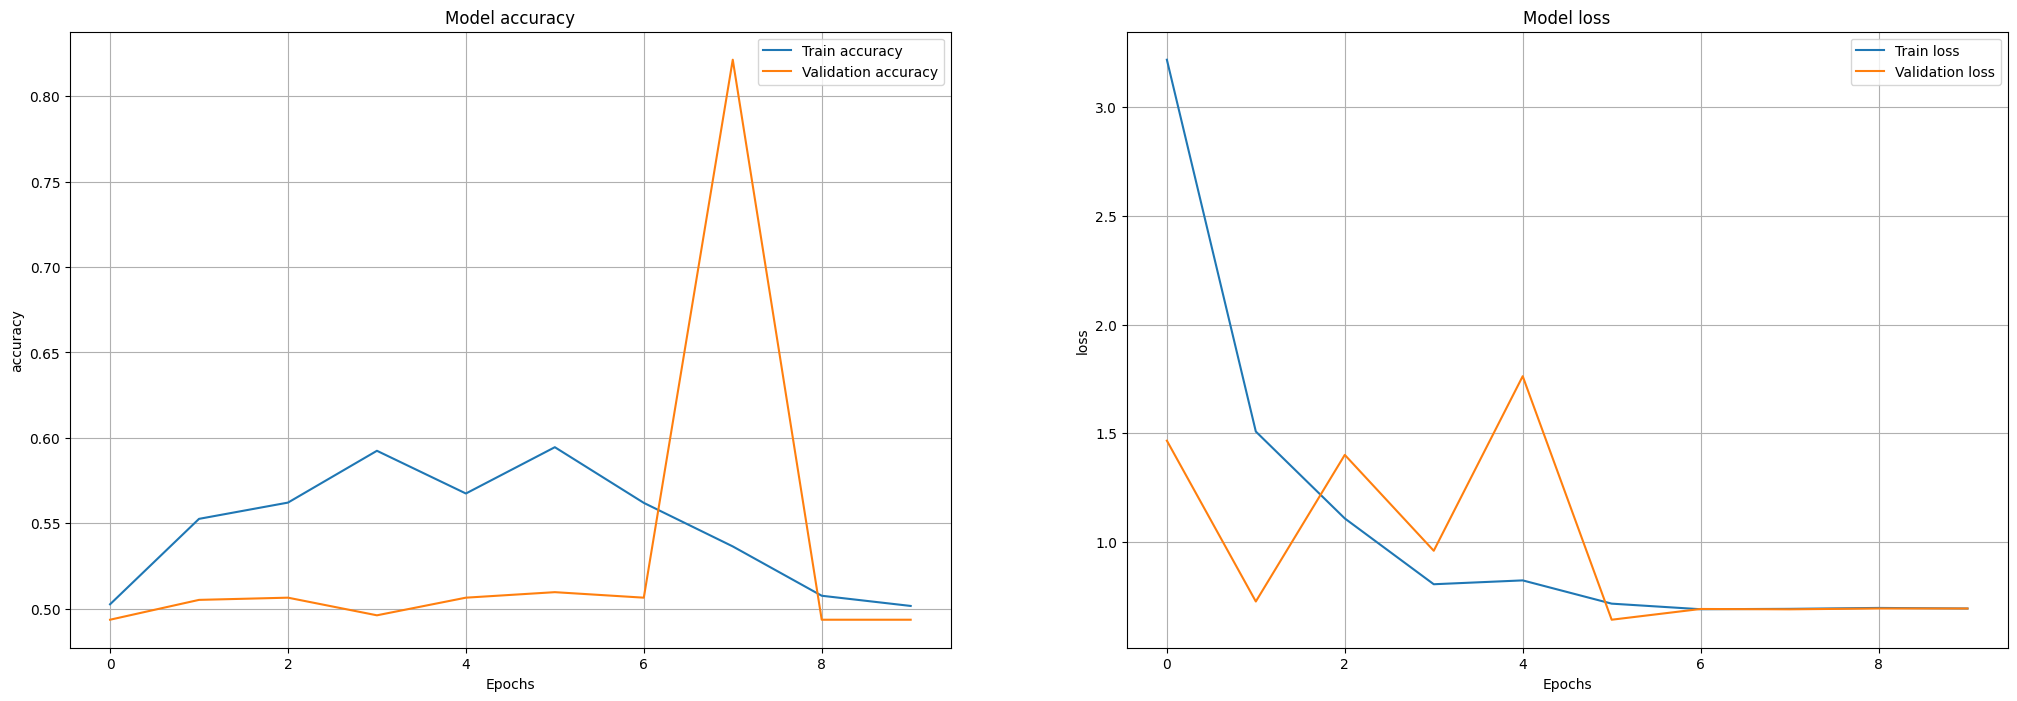

49/49 [==============================] - 2s 44ms/step - loss: 0.6932 - accuracy: 0.5000

Test accuracy: 0.5, Test loss: 0.6932039856910706
49/49 [==============================] - 4s 32ms/step

Confusion Matrix:


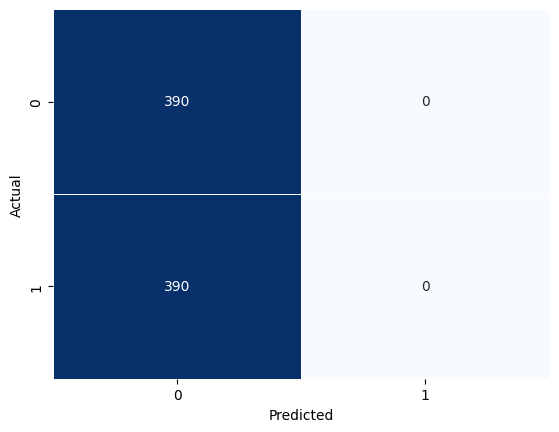


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.50      1.00      0.67       390
   PNEUMONIA       1.00      0.00      0.00       390

    accuracy                           0.50       780
   macro avg       0.75      0.50      0.33       780
weighted avg       0.75      0.50      0.33       780



In [22]:
# history_eff_v2 = eff_v2.fit(train_data, epochs=20,validation_data = val_data)
evaluate_model(model=eff_v2, train_dataset=train_data, val_dataset=val_data, test_dataset=test_data, epochs=10)

## <b> 5. Using Attention Mechanism </b>
<a id='att'></a>

### 5.1 Self-Attention
<a id='selfAtt'></a>

In [23]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers:
    layer.trainable = False

The `SelfAttention` class is a custom implementation of a self-attention mechanism, which is a simplified version of the multi-head attention mechanism. The self-attention mechanism allows the model to weigh the importance of different features in the input by attending to different parts of the input. Here's a breakdown of the `SelfAttention` class:

1. `__init__(self, d_k)`: The constructor takes a single argument `d_k`, which is the dimension of the key, query, and value vectors in the attention mechanism. It initializes the class by calling the base class constructor and storing the `d_k` value.

2. `build(self, input_shape)`: This method is called when the layer is added to the model, and it initializes the weight matrices for the key (WK), query (WQ), and value (WV) projections. The weight matrices are of shape `(input_shape[-1], self.d_k)` and are initialized using the Glorot uniform distribution.

3. `call(self, inputs)`: This method is called during the forward pass of the model when the layer processes the input data. It takes the input tensor and does the following:

   a. Computes the query (Q), key (K), and value (V) matrices by multiplying the input tensor with the corresponding weight matrices (WQ, WK, WV).
   
   b. Calculates the attention logits by computing the dot product of the query (Q) and key (K) matrices, and scales the result by the square root of `d_k` to avoid gradients becoming too small or too large.
   
   c. Applies the softmax function to the attention logits to obtain the attention weights, which represent the importance of each feature in the input.
   
   d. Computes the attention output by multiplying the attention weights with the value (V) matrix. This output is a weighted sum of the input features according to their attention weights.
   
The `SelfAttention` layer outputs the attention output, which can be fed to the next layer in the model. In our case, it is followed by the classification layer with a softmax activation function.

In [24]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_k):
        super(SelfAttention, self).__init__()
        self.d_k = d_k

    def build(self, input_shape):
        self.WQ = self.add_weight(name='WQ', shape=(input_shape[-1], self.d_k), initializer='glorot_uniform', trainable=True)
        self.WK = self.add_weight(name='WK', shape=(input_shape[-1], self.d_k), initializer='glorot_uniform', trainable=True)
        self.WV = self.add_weight(name='WV', shape=(input_shape[-1], self.d_k), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        Q = tf.linalg.matmul(inputs, self.WQ)
        K = tf.linalg.matmul(inputs, self.WK)
        V = tf.linalg.matmul(inputs, self.WV)
        attention_logits = tf.linalg.matmul(Q, K, transpose_b=True) / tf.sqrt(tf.cast(self.d_k, tf.float32))
        attention_weights = tf.nn.softmax(attention_logits, axis=-1)
        attention_output = tf.linalg.matmul(attention_weights, V)
        return attention_output

In [25]:
global_avg_pool = layers.GlobalAveragePooling2D()(base_model.output)
attention_output = SelfAttention(d_k=64)(global_avg_pool)
predictions = layers.Dense(1, activation='sigmoid')(attention_output)
model_selfAtt = Model(inputs=base_model.input, outputs=predictions)

model_selfAtt.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/10
388/388 [==============================] - 22s 52ms/step - loss: 0.7007 - accuracy: 0.5155 - val_loss: 0.6751 - val_accuracy: 0.7181
Epoch 2/10
388/388 [==============================] - 20s 51ms/step - loss: 0.5499 - accuracy: 0.7852 - val_loss: 0.4222 - val_accuracy: 0.8490
Epoch 3/10
388/388 [==============================] - 20s 51ms/step - loss: 0.3561 - accuracy: 0.8750 - val_loss: 0.3190 - val_accuracy: 0.8832
Epoch 4/10
388/388 [==============================] - 20s 51ms/step - loss: 0.3043 - accuracy: 0.8916 - val_loss: 0.2992 - val_accuracy: 0.8877
Epoch 5/10
388/388 [==============================] - 20s 51ms/step - loss: 0.2875 - accuracy: 0.8966 - val_loss: 0.2824 - val_accuracy: 0.8865
Epoch 6/10
388/388 [==============================] - 20s 51ms/step - loss: 0.2694 - accuracy: 0.9039 - val_loss: 0.2688 - val_accuracy: 0.8987
Epoch 7/10
388/388 [==============================] - 20s 51ms/step - loss: 0.2575 - accuracy: 0.9082 - val_loss: 0.2588 - val_accuracy:

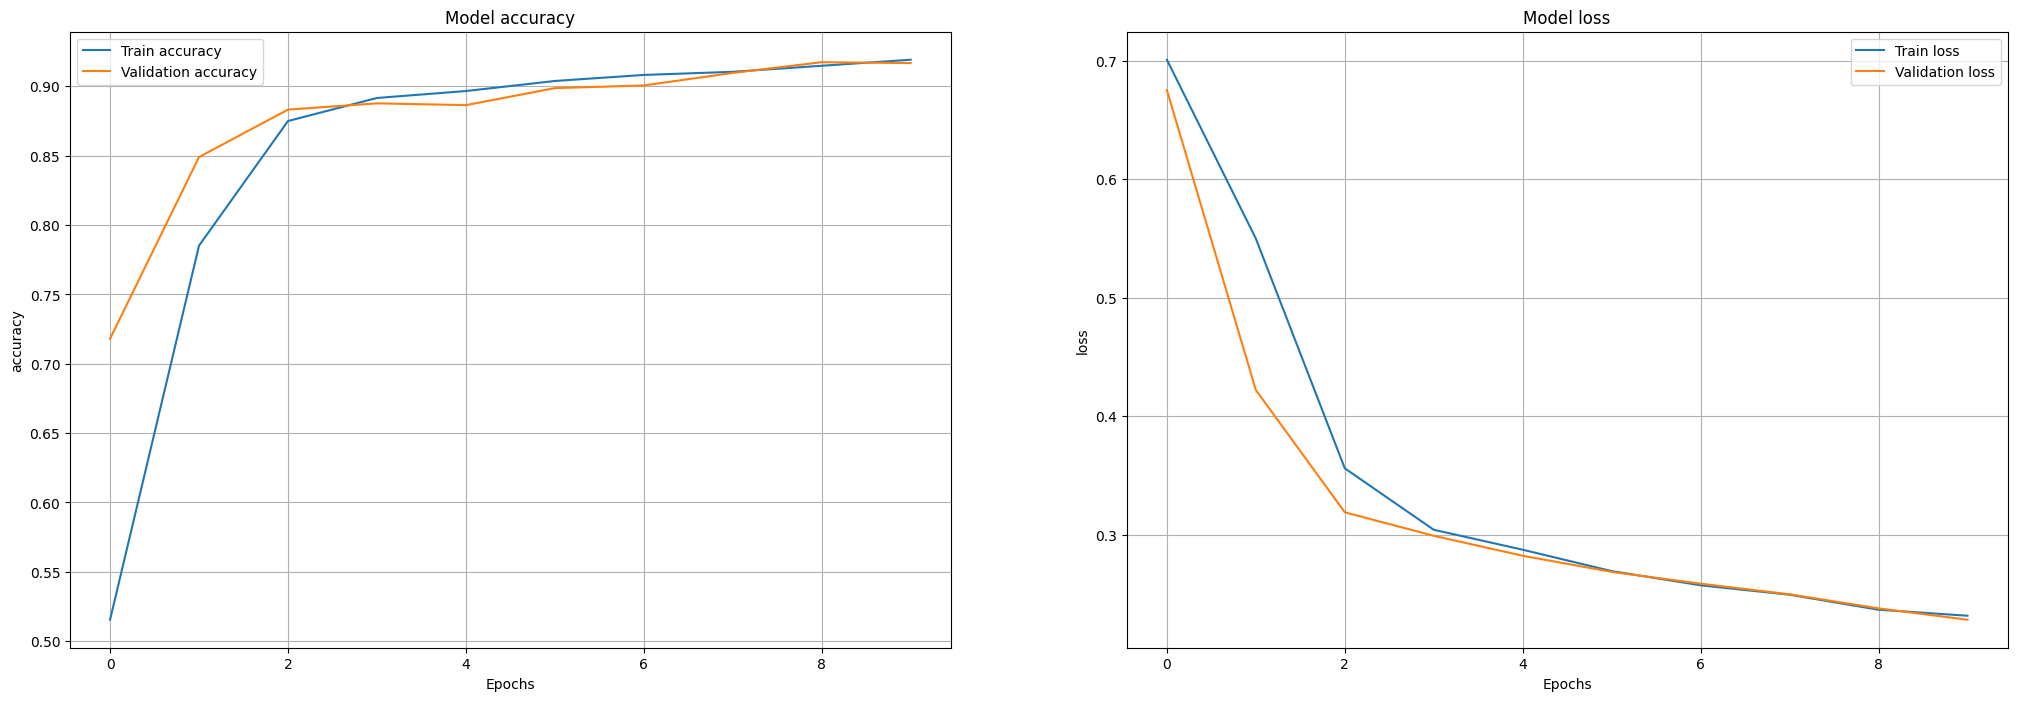

49/49 [==============================] - 2s 39ms/step - loss: 0.5337 - accuracy: 0.7692

Test accuracy: 0.7692307829856873, Test loss: 0.5336529612541199
49/49 [==============================] - 2s 38ms/step

Confusion Matrix:


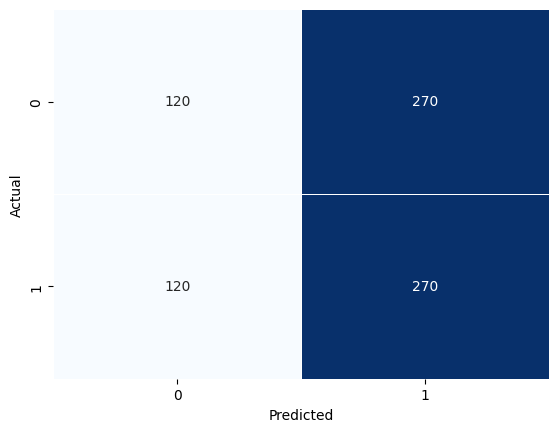


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.50      0.31      0.38       390
   PNEUMONIA       0.50      0.69      0.58       390

    accuracy                           0.50       780
   macro avg       0.50      0.50      0.48       780
weighted avg       0.50      0.50      0.48       780



In [26]:
evaluate_model(model=model_selfAtt, train_dataset=train_data, val_dataset=val_data, test_dataset=test_data, epochs=10)

### 5.2 MultiHead Attention
<a id='multHead'></a>

In [27]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_k):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.d_k = d_k
        self.attention_heads = [SelfAttention(d_k=self.d_k) for _ in range(self.num_heads)]

    def call(self, inputs):
        attention_outputs = [head(inputs) for head in self.attention_heads]
        multihead_output = tf.concat(attention_outputs, axis=-1)
        return multihead_output

In [28]:
flatten_output = layers.Flatten()(base_model.output)
global_avg_pool = layers.GlobalAveragePooling1D()(flatten_output[:, None, :])
attention_output = MultiHeadSelfAttention(num_heads=2, d_k=64)(global_avg_pool)
flatten_attention_output = layers.Flatten()(attention_output)
predictions = layers.Dense(1, activation='sigmoid')(flatten_attention_output)
model_multHdAtt = Model(inputs=base_model.input, outputs=predictions)

model_multHdAtt.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/10
388/388 [==============================] - 23s 52ms/step - loss: 1.1093 - accuracy: 0.5082 - val_loss: 1.0402 - val_accuracy: 0.4800
Epoch 2/10
388/388 [==============================] - 20s 52ms/step - loss: 1.0958 - accuracy: 0.5074 - val_loss: 1.3722 - val_accuracy: 0.4871
Epoch 3/10
388/388 [==============================] - 20s 51ms/step - loss: 0.9588 - accuracy: 0.4998 - val_loss: 0.8635 - val_accuracy: 0.5052
Epoch 4/10
388/388 [==============================] - 20s 52ms/step - loss: 0.9342 - accuracy: 0.5221 - val_loss: 1.2092 - val_accuracy: 0.4935
Epoch 5/10
388/388 [==============================] - 20s 51ms/step - loss: 0.8047 - accuracy: 0.5602 - val_loss: 0.4258 - val_accuracy: 0.8258
Epoch 6/10
388/388 [==============================] - 20s 51ms/step - loss: 0.3160 - accuracy: 0.8829 - val_loss: 0.2332 - val_accuracy: 0.9277
Epoch 7/10
388/388 [==============================] - 20s 52ms/step - loss: 0.2404 - accuracy: 0.9235 - val_loss: 0.1710 - val_accuracy:

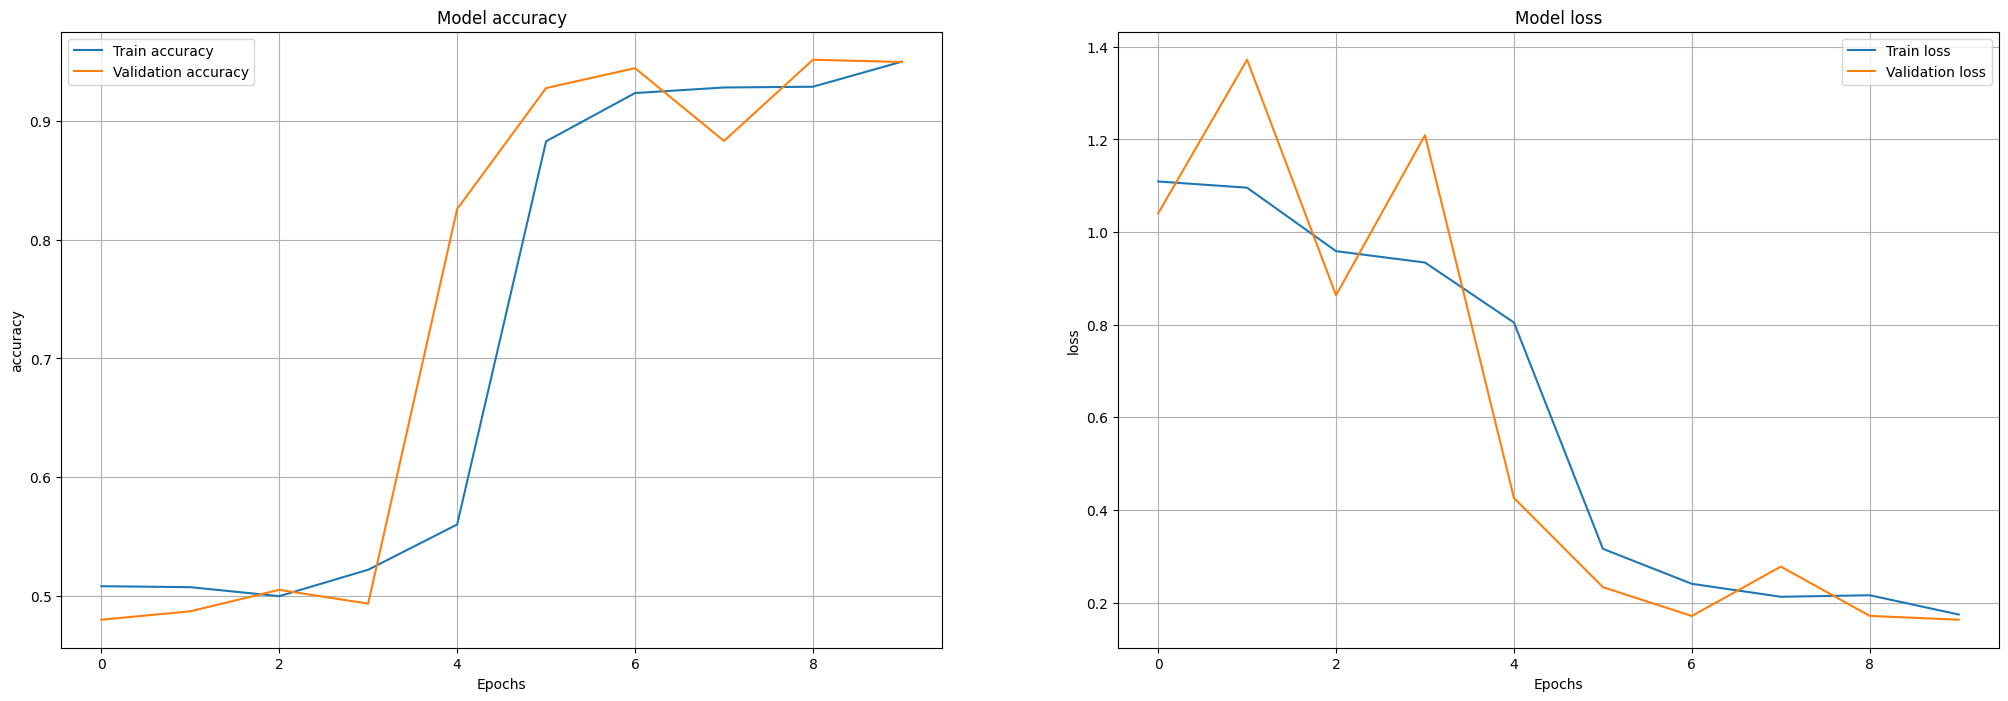

49/49 [==============================] - 2s 40ms/step - loss: 0.6770 - accuracy: 0.8128

Test accuracy: 0.8128204941749573, Test loss: 0.6769720911979675
49/49 [==============================] - 2s 38ms/step

Confusion Matrix:


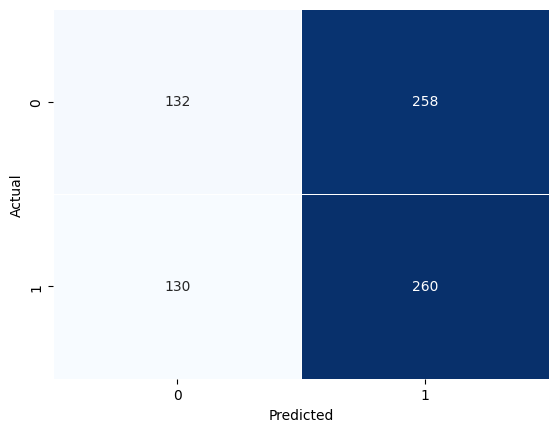


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.50      0.34      0.40       390
   PNEUMONIA       0.50      0.67      0.57       390

    accuracy                           0.50       780
   macro avg       0.50      0.50      0.49       780
weighted avg       0.50      0.50      0.49       780



In [29]:
evaluate_model(model=model_multHdAtt, train_dataset=train_data, val_dataset=val_data, test_dataset=test_data, epochs=10)

## <b> 6. Visual Transformers (ViT) </b>
<a id='vit'></a>

In [30]:
def create_vit_classifier():
    model = vit.vit_b32(
        image_size=img_height,
        activation='sigmoid',
        pretrained=True,
        include_top=True,
        pretrained_top=False,
        classes=1,
        weights='imagenet21k'
    )

    input_layer = tf.keras.layers.Input(shape=(img_height, img_width, 3))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input_layer)
    output = model(x)

    return tf.keras.Model(inputs=input_layer, outputs=output)

model_vit = create_vit_classifier()
model_vit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       metrics=['accuracy'])

/home/ubuntu/AASD-4015---COVID-19-Detection/covid/lib/python3.8/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 7, 7 to 10, 10
  warnings.warn(


Epoch 1/10
388/388 [==============================] - 108s 154ms/step - loss: 0.7276 - accuracy: 0.4985 - val_loss: 0.6937 - val_accuracy: 0.5065
Epoch 2/10
388/388 [==============================] - 57s 146ms/step - loss: 0.6988 - accuracy: 0.4985 - val_loss: 0.6934 - val_accuracy: 0.4935
Epoch 3/10
388/388 [==============================] - 57s 146ms/step - loss: 0.6990 - accuracy: 0.5058 - val_loss: 0.6945 - val_accuracy: 0.4935
Epoch 4/10
388/388 [==============================] - 57s 146ms/step - loss: 0.6992 - accuracy: 0.4885 - val_loss: 0.6941 - val_accuracy: 0.5065
Epoch 5/10
388/388 [==============================] - 57s 146ms/step - loss: 0.6973 - accuracy: 0.5006 - val_loss: 0.7035 - val_accuracy: 0.4935
Epoch 6/10
388/388 [==============================] - 57s 146ms/step - loss: 0.6972 - accuracy: 0.4976 - val_loss: 0.6950 - val_accuracy: 0.4935
Epoch 7/10
388/388 [==============================] - 57s 146ms/step - loss: 0.6963 - accuracy: 0.4916 - val_loss: 0.6935 - val_a

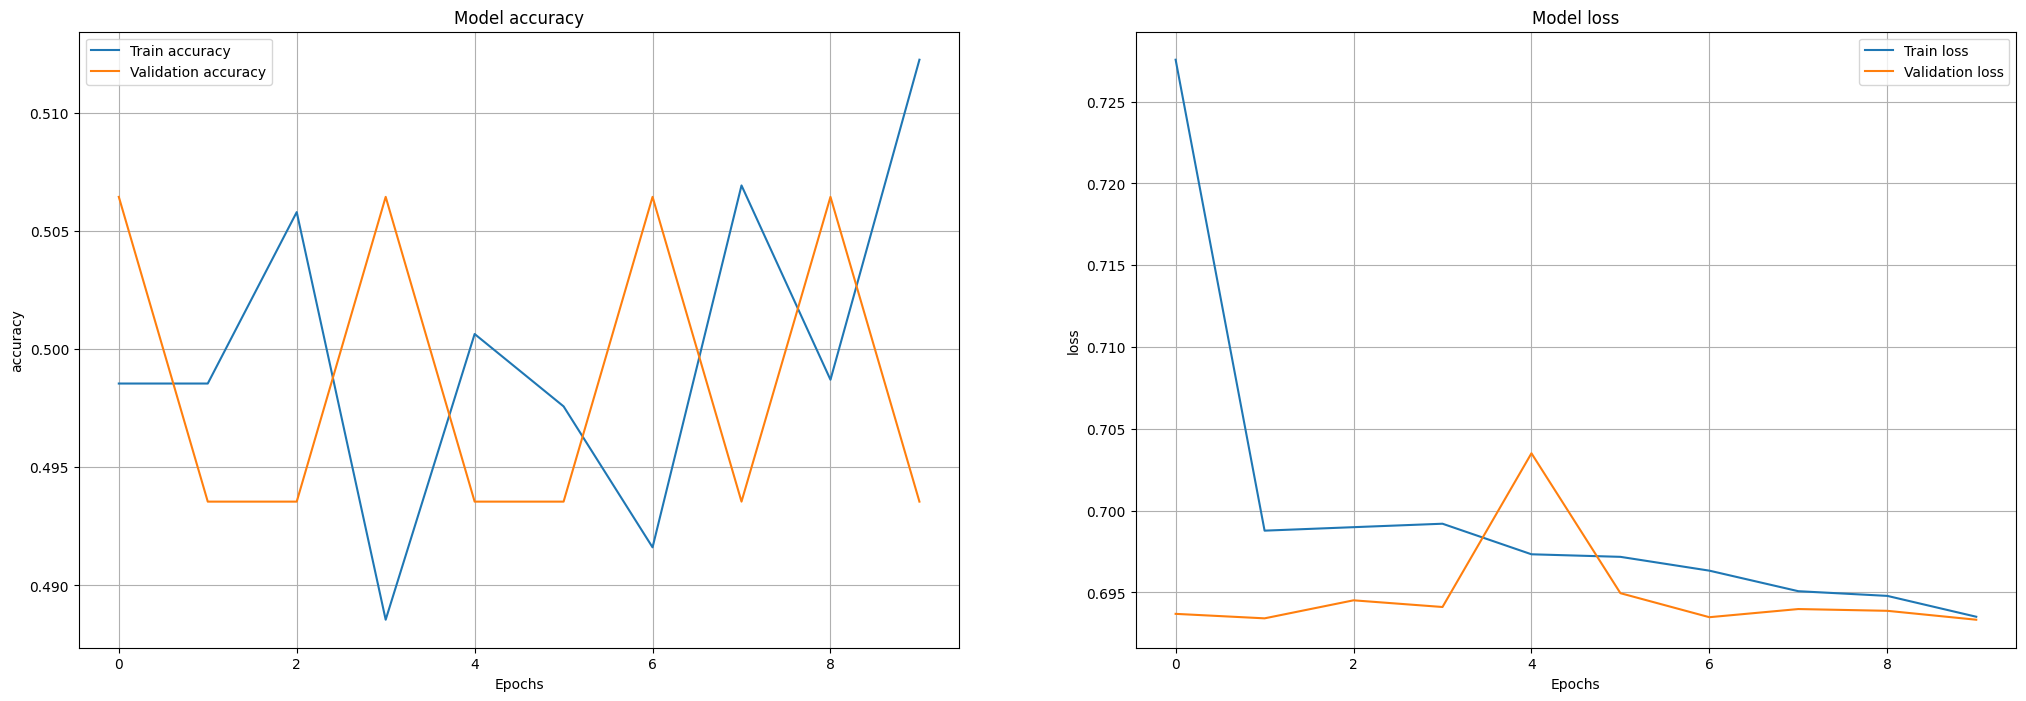

49/49 [==============================] - 3s 60ms/step - loss: 0.6932 - accuracy: 0.5000

Test accuracy: 0.5, Test loss: 0.6931963562965393
49/49 [==============================] - 6s 59ms/step

Confusion Matrix:


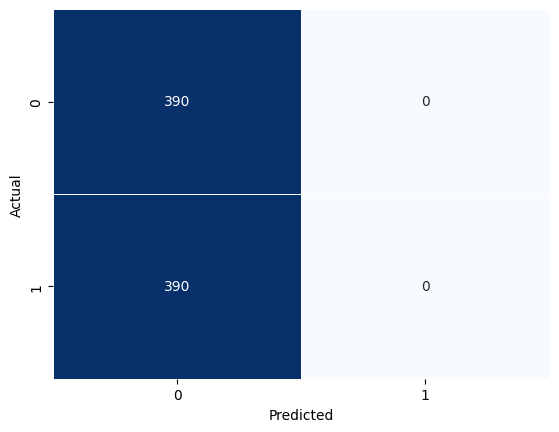


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.50      1.00      0.67       390
   PNEUMONIA       1.00      0.00      0.00       390

    accuracy                           0.50       780
   macro avg       0.75      0.50      0.33       780
weighted avg       0.75      0.50      0.33       780



In [31]:
evaluate_model(model=model_vit, train_dataset=train_data, val_dataset=val_data, test_dataset=test_data, epochs=10)

## <b> 7. Results </b>
<a id='results'></a>

| SNo. | Training | Parameters | Accuracy | Precision | <b> Recall </b> | F1 Score | Comments
| -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- |
| 1 | VGG-16 + Dense head | 0 |  | 2  | <b> test </b>| | a
| 2 | Inception-V3 + Dense head |  | 0 | 58m |
| 3 | EfficientNetV2B3 + Dense head |  | 0 | 11m |
| 4 | VGG-16 + SelfAttention Head |  | 0 | 11m |
| 5 | VGG-16 + MultiHead Attention |  | 0 | 11m |
| 6 | ViT | 0 | 0 | 11 | 


## <b> 8. Conclusions </b>
<a id='conclusion'></a>

## <b> 9. Learning Outcomes </b>
<a id='learningOuts'></a>

1. Gained experience in implementing custom models in keras with custom architec

## <b> 10. References </b>
<a id='ref'></a>


1. Mooney, P. T. (n.d.). Chest X-Ray Images (Pneumonia). Kaggle. Retrieved from https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
   
2. Lemaitre, G., Nogueira, F., & Aridas, C. K. (n.d.). imblearn.over_sampling.RandomOverSampler. imbalanced-learn. Retrieved from https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
   
3. Weights & Biases Authors. (n.d.). Simple Ways to Tackle Class Imbalance. Weights & Biases. Retrieved from https://wandb.ai/authors/class-imbalance/reports/Simple-Ways-to-Tackle-Class-Imbalance--VmlldzoxODA3NTk
   
4. Stack Overflow Contributors. (2017, November 14). Oversampling functionality in TensorFlow Dataset API. Stack Overflow. Retrieved from https://stackoverflow.com/questions/47236465/oversampling-functionality-in-tensorflow-dataset-api
   
5. Mooney, P. T. (n.d.). Exploring the Kaggle API. Kaggle. Retrieved from https://www.kaggle.com/code/paultimothymooney/exploring-the-kaggle-api
   
6. Morales, F. (n.d.). vit-keras: Implementation of Vision Transformers in Keras. GitHub. Retrieved from https://github.com/faustomorales/vit-keras
   
7. Morales, F., & Contributors (n.d.). Issue #35: How to use ViT for regression? GitHub. Retrieved from https://github.com/faustomorales/vit-keras/issues/35
   
8. Papers with Code Contributors (n.d.). Vision Transformer Method Page on Papers with Code. Papers with Code. Retrieved from https://paperswithcode.com/method/vision-transformer
   
9.  TensorFlow Contributors (n.d.). tf.keras.layers.MultiHeadAttention API documentation page on TensorFlow.org. TensorFlow.org. Retrieved from https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention 
    
10. TensorFlow Contributors (n.d.). Neural machine translation with attention tutorial on TensorFlow.org Text Tutorials section.TensorFlow.org.Retrieved from https://www.tensorflow.org/text/tutorials/nmt_with_attention
    
11. Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A.N., Kaiser,L., & Polosukhin,I.(2017). Attention Is All You Need.arXiv preprint arXiv:1706.03762.Retrieved from https://arxiv.org/pdf/1706.03762.pdf
    
12. ChatGPT. (2023, April 1 - 2023, April 6). [Mostly debugging questions from code implementation of concepts] [Response to the user questions]. Retrieved from https://chat.openai.com/chat